#### Section 1: Importing Necessary Libraries

In [9]:
### Basic Imports
import numpy as np
import pandas as pd
import random
import toml
import os
import logging
import math
import json
from datetime import datetime
import seaborn as sns
### Matplot Lib Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Parallel Processing Libraries
from functools import partial
import time
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import concurrent.futures

### Scipy Imports
from scipy.spatial import distance
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
### Other Imports
import warnings
from copy import deepcopy
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any
from abc import ABC, abstractmethod
from matplotlib.colors import LinearSegmentedColormap
from typing import List, Dict, Tuple, Optional
import itertools

#### Section 1.1: Basic Utility Functions

In [10]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def create_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i][j] = euclidean_distance(locations[i], locations[j])
    return matrix

def create_charging_distance_matrix(locations, charging_stations):
    matrix = np.zeros((len(locations), len(charging_stations)))
    for i, loc in enumerate(locations):
        for j, station in enumerate(charging_stations):
            matrix[i][j] = euclidean_distance(loc, station)
    return matrix

In [11]:
class EVRPSolution:
    def __init__(self):
        self.routes = []
        self.vehicle_types = []
        self.route_loads = []
        self.route_distances = []
        self.route_energies = []
        self.delivery_times = []
        self.computation_time = 0.0

    def add_route(self, route, vehicle_type, load):
        self.routes.append(route)
        self.vehicle_types.append(vehicle_type)
        self.route_loads.append(load)

In [12]:
class EVConfig:
    def __init__(self):
        self.categories = {
            'small': {
                'battery_capacity': 35,
                'base_weight': 1500,
                'load_capacity': 500
            },
            'medium': {
                'battery_capacity': 40,
                'base_weight': 1800,
                'load_capacity': 600
            },
            'large': {
                'battery_capacity': 45,
                'base_weight': 2000,
                'load_capacity': 700
            },
            'xlarge': {
                'battery_capacity': 50,
                'base_weight': 2200,
                'load_capacity': 800
            }
        }
        self.initial_charging = 100
        self.speed = 25
        self.energy_consumption_rate = 0.15
        self.weight_factor = 0.05
        self.battery_safety_margin = 40

In [13]:
class EVRPInstance:
    def __init__(self, instance_id, depot_location, customer_locations, 
                 charging_stations, customer_items_weights, charging_rate):
        self.instance_id = instance_id
        self.depot_location = depot_location
        self.customer_locations = customer_locations
        self.charging_stations = charging_stations
        self.customer_items_weights = customer_items_weights
        self.charging_rate = charging_rate
        
        # Create distance matrices
        self.distance_matrix = self._create_distance_matrix()
        self.charging_distance_matrix = self._create_charging_distance_matrix()

    def _create_distance_matrix(self):
        locations = [self.depot_location] + self.customer_locations
        return create_distance_matrix(locations)

    def _create_charging_distance_matrix(self):
        locations = [self.depot_location] + self.customer_locations
        return create_charging_distance_matrix(locations, self.charging_stations)

In [14]:
class GreedyEVRPSolver:
    def __init__(self, instance: EVRPInstance):
        self.instance = instance
        self.ev_config = EVConfig()
        self.best_solution = EVRPSolution()
        self.served_customers = set()
        self.fleet = {
            'xlarge': 0,
            'large': 0,
            'medium': 0,
            'small': 0
        }
        
    def calculate_min_vehicles_needed(self) -> Dict[str, int]:
        total_demand = sum(self.instance.customer_items_weights)
        unit_fleet_capacity = sum(
            self.ev_config.categories[v_type]['load_capacity']
            for v_type in ['xlarge', 'large', 'medium', 'small']
        )
        min_vehicles = math.ceil(total_demand / unit_fleet_capacity)
        return {
            'xlarge': min_vehicles,
            'large': min_vehicles,
            'medium': min_vehicles,
            'small': min_vehicles
        }

    def increase_fleet_binary(self, current_fleet: Dict[str, int]) -> Dict[str, int]:
        """Increase fleet following binary pattern"""
        # Get base value (minimum number of vehicles)
        base = min(current_fleet.values())
        
        # Convert current configuration to binary
        binary = ''
        for v_type in ['xlarge', 'large', 'medium', 'small']:
            binary += '1' if current_fleet[v_type] > base else '0'
        
        # Increment binary pattern
        current_value = int(binary, 2)
        next_value = current_value + 1
        
        # If we've used all patterns (1111), increment base
        if next_value > 15:  # 15 is 1111 in binary
            base += 1
            next_value = 0
        
        # Convert back to binary
        new_binary = format(next_value, '04b')
        
        # Create new fleet configuration
        new_fleet = {}
        for i, v_type in enumerate(['xlarge', 'large', 'medium', 'small']):
            new_fleet[v_type] = base + (1 if new_binary[i] == '1' else 0)
        
        return new_fleet
    
    def calculate_proportional_loads(self, fleet: Dict[str, int], total_demand: float) -> Dict[str, float]:
        proportional_loads = {}
        vehicle_capacities = {}
        total_vehicles = 0
        
        # Get vehicle capacities and count total vehicles
        for v_type, count in fleet.items():
            if count > 0:
                vehicle_capacities[v_type] = self.ev_config.categories[v_type]['load_capacity']
                total_vehicles += count
        
        if total_vehicles == 0:
            return {v_type: 0 for v_type in fleet}
        
        # Calculate base load per vehicle (equal distribution)
        base_load_per_vehicle = total_demand / total_vehicles
        
        # First pass: Assign base load or capacity, whichever is smaller
        remaining_demand = total_demand
        remaining_vehicles = total_vehicles
        
        for v_type in fleet:
            if fleet[v_type] > 0:
                capacity = vehicle_capacities[v_type]
                count = fleet[v_type]
                
                # Assign minimum of base load or capacity
                load_per_vehicle = min(base_load_per_vehicle, capacity)
                proportional_loads[v_type] = load_per_vehicle
                
                # Update remaining demand and vehicles
                actual_load = load_per_vehicle * count
                remaining_demand -= actual_load
                if load_per_vehicle < base_load_per_vehicle:
                    remaining_vehicles -= count
        
        # Second pass: Redistribute excess to vehicles with remaining capacity
        if remaining_demand > 0 and remaining_vehicles > 0:
            additional_load_per_vehicle = remaining_demand / remaining_vehicles
            
            for v_type in fleet:
                if fleet[v_type] > 0:
                    current_load = proportional_loads[v_type]
                    capacity = vehicle_capacities[v_type]
                    
                    if current_load < capacity:
                        # Can take more load
                        new_load = min(capacity, current_load + additional_load_per_vehicle)
                        proportional_loads[v_type] = new_load
        
        # Add zero loads for unused vehicle types
        for v_type in fleet:
            if v_type not in proportional_loads:
                proportional_loads[v_type] = 0
        
        # Print distribution information
        print(f"\nLoad Distribution Details:")
        print(f"Total Demand: {total_demand:.2f}")
        print(f"Base Load Per Vehicle: {base_load_per_vehicle:.2f}")
        print("\nPer Vehicle Type Assignment:")
        
        total_allocated = 0
        for v_type in proportional_loads:
            if fleet[v_type] > 0:
                load = proportional_loads[v_type]
                capacity = vehicle_capacities[v_type]
                count = fleet[v_type]
                total_type_load = load * count
                total_allocated += total_type_load
                
                print(f"{v_type:>8}: {load:.2f} kg/vehicle × {count} vehicles = {total_type_load:.2f} kg "
                    f"(capacity: {capacity:.2f} kg)")
        
        print(f"\nTotal Allocated: {total_allocated:.2f} kg")
        
        return proportional_loads

    def create_route(self, unserved_customers: List[int], vehicle_type: str, 
                target_load: float) -> Tuple[List[int], float]:
        """
        Create a route allowing only one customer to exceed the proportional load target.
        
        Args:
            unserved_customers: List of customer indices not yet served
            vehicle_type: Type of vehicle ('small', 'medium', 'large', 'xlarge')
            target_load: Target proportional load for this vehicle type
                
        Returns:
            Tuple containing:
            - List[int]: Route (sequence of customer indices, starting and ending with depot)
            - float: Total load for the route
        """
        route = [0]  # Start from depot
        current_load = 0
        current_battery = self.ev_config.initial_charging
        allowed_excess = True  # Flag to track if we can still allow one customer to exceed
        vehicle_capacity = self.ev_config.categories[vehicle_type]['load_capacity']
        
        while unserved_customers:
            next_customer = self.find_best_next_customer(
                current_pos=route[-1],
                unserved_customers=unserved_customers,
                vehicle_type=vehicle_type,
                current_load=current_load,
                current_battery=current_battery,
                route=route
            )
            
            if next_customer is None:
                break
                
            customer_demand = self.instance.customer_items_weights[next_customer]
            is_last_customer = len(unserved_customers) == 1
            
            # Check if adding this customer would exceed vehicle capacity
            if current_load + customer_demand > vehicle_capacity:
                break
                
            # Check if adding this customer would exceed target load
            exceeds_target = current_load + customer_demand > target_load
            
            if exceeds_target:
                if allowed_excess and not is_last_customer:
                    # Allow this customer but mark that we can't exceed again
                    allowed_excess = False
                else:
                    # We've already used our one excess or it's the last customer
                    break
                    
            customer_id = next_customer + 1
            route.append(customer_id)
            current_load += customer_demand
            
            # Update battery level after visiting the customer
            distance = self.calculate_distance(route[-2], customer_id)
            energy_consumed = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            current_battery -= energy_consumed
            
            self.served_customers.add(next_customer)
            unserved_customers.remove(next_customer)
            
        route.append(0)  # Return to depot
        return route, current_load

    

    def calculate_angle_change(self, point1: Tuple[float, float],
                            point2: Tuple[float, float],
                            point3: Tuple[float, float]) -> float:
        """Calculate the angle change between three points in degrees"""
        import math
        
        # Calculate vectors
        vector1 = (point1[0] - point2[0], point1[1] - point2[1])
        vector2 = (point3[0] - point2[0], point3[1] - point2[1])
        
        # Calculate dot product
        dot_product = vector1[0] * vector2[0] + vector1[1] * vector2[1]
        
        # Calculate magnitudes
        magnitude1 = math.sqrt(vector1[0]**2 + vector1[1]**2)
        magnitude2 = math.sqrt(vector2[0]**2 + vector2[1]**2)
        
        # Calculate angle in degrees
        if magnitude1 == 0 or magnitude2 == 0:
            return 0
            
        cos_angle = dot_product / (magnitude1 * magnitude2)
        cos_angle = max(min(cos_angle, 1), -1)  # Ensure value is in [-1, 1]
        angle = math.degrees(math.acos(cos_angle))
        
        return angle

    def solve(self) -> EVRPSolution:
        """Main solving procedure trying multiple weight configurations, optimizing for minimum travel time"""
        total_demand = sum(self.instance.customer_items_weights)
        self.fleet = self.calculate_min_vehicles_needed()
        max_attempts = 16  # Maximum number of fleet configurations to try
        
        # Define different weight configurations to try
        weight_configurations = [
            # Time-focused (prioritize direct routes and battery management)
            {
                'distance': 0.4,
                'capacity': 0.1,
                'battery': 0.3,
                'urgency': 0.1,
                'clustering': 0.05,
                'compactness': 0.05
            },
            # Time-Cluster balanced (focus on serving nearby customers efficiently)
            {
                'distance': 0.3,
                'capacity': 0.1,
                'battery': 0.2,
                'urgency': 0.1,
                'clustering': 0.2,
                'compactness': 0.1
            },
            # Battery-efficient (minimize charging stops)
            {
                'distance': 0.2,
                'capacity': 0.1,
                'battery': 0.4,
                'urgency': 0.1,
                'clustering': 0.1,
                'compactness': 0.1
            },
            # Compact routes (minimize zigzagging)
            {
                'distance': 0.25,
                'capacity': 0.1,
                'battery': 0.25,
                'urgency': 0.1,
                'clustering': 0.1,
                'compactness': 0.2
            },
            # High-capacity utilization (fewer vehicles)
            {
                'distance': 0.2,
                'capacity': 0.3,
                'battery': 0.2,
                'urgency': 0.1,
                'clustering': 0.1,
                'compactness': 0.1
            }
        ]
        
        best_solution = None
        best_time = float('inf')
        best_weight_config = None
        best_fleet_config = None
        
        for config_idx, weight_config in enumerate(weight_configurations, 1):
            print(f"\nTrying weight configuration {config_idx}/{len(weight_configurations)}:")
            for key, value in weight_config.items():
                print(f"  {key}: {value:.2f}")
                
            self.fleet = self.calculate_min_vehicles_needed()
            attempt = 0
            
            while attempt < max_attempts:
                print(f"\nAttempt {attempt + 1}: Fleet configuration: {self.fleet}")
                solution = EVRPSolution()
                solution.computation_time = 0.0
                self.served_customers.clear()
                
                proportional_loads = self.calculate_proportional_loads(self.fleet, total_demand)
                
                # Create routes for each vehicle type
                for v_type in ['small', 'medium', 'large', 'xlarge']:
                    num_vehicles = self.fleet[v_type]
                    if num_vehicles == 0:
                        continue
                        
                    print(f"\nAssigning customers to {v_type} vehicles")
                    print(f"Target load per vehicle: {proportional_loads[v_type]:.2f} kg")
                    
                    for vehicle_num in range(num_vehicles):
                        if len(self.served_customers) == len(self.instance.customer_locations):
                            break
                            
                        unserved = [i for i in range(len(self.instance.customer_locations)) 
                                if i not in self.served_customers]
                        
                        route, load = self.create_route(unserved, v_type, 
                                                    proportional_loads[v_type],
                                                    weight_config)
                        
                        if route and len(route) > 2:  # If route contains any customers
                            route_with_charging = self.insert_charging_stations(route, load, v_type)
                            distance, energy, time, battery_levels = self.calculate_route_metrics(
                                route_with_charging, load, v_type)
                            
                            solution.add_route(route_with_charging, v_type, load)
                            solution.route_distances.append(distance)
                            solution.route_energies.append(energy)
                            solution.delivery_times.append(time)
                            
                            print(f"Route {vehicle_num + 1}: {len(route)-2} customers, "
                                f"Time: {time:.2f} min, Load: {load:.2f} kg")
                
                unserved_count = len(self.instance.customer_locations) - len(self.served_customers)
                
                if unserved_count == 0:
                    total_time = sum(solution.delivery_times)
                    max_route_time = max(solution.delivery_times)
                    total_distance = sum(solution.route_distances)
                    total_energy = sum(solution.route_energies)
                    
                    print(f"\nSolution metrics:")
                    print(f"Total time: {total_time:.2f} minutes")
                    print(f"Max route time: {max_route_time:.2f} minutes")
                    print(f"Total distance: {total_distance:.2f} km")
                    print(f"Total energy: {total_energy:.2f} kWh")
                    
                    # Update best solution if this has lower total time
                    if total_time < best_time:
                        best_time = total_time
                        best_solution = solution
                        best_weight_config = weight_config
                        best_fleet_config = self.fleet.copy()
                        print("\nNew best solution found!")
                        print(f"Previous best time: {best_time:.2f} minutes")
                        print("Weight configuration:")
                        for key, value in best_weight_config.items():
                            print(f"  {key}: {value:.2f}")
                    
                    break
                else:
                    print(f"\nWarning: {unserved_count} customers remain unserved")
                    self.fleet = self.increase_fleet_binary(self.fleet)
                    attempt += 1
        
        if best_solution:
            print("\nFinal best solution:")
            print(f"Total time: {best_time:.2f} minutes")
            print("\nBest weight configuration:")
            for key, value in best_weight_config.items():
                print(f"  {key}: {value:.2f}")
            print("\nBest fleet configuration:", best_fleet_config)
            
            # Print detailed route statistics
            print("\nDetailed route statistics:")
            for i, (route, v_type, distance, time, energy) in enumerate(zip(
                best_solution.routes, 
                best_solution.vehicle_types,
                best_solution.route_distances,
                best_solution.delivery_times,
                best_solution.route_energies
            )):
                print(f"\nRoute {i+1} ({v_type}):")
                print(f"  Customers: {[c for c in route if c > 0]}")
                print(f"  Time: {time:.2f} minutes")
                print(f"  Distance: {distance:.2f} km")
                print(f"  Energy: {energy:.2f} kWh")
            
            return best_solution
        else:
            print("\nNo feasible solution found within maximum attempts")
            return EVRPSolution()
    def create_route(self, unserved_customers: List[int], vehicle_type: str, 
                    target_load: float, weights: Dict[str, float]) -> Tuple[List[int], float]:
        """
        Create a route using the specified weight configuration.
        """
        route = [0]  # Start from depot
        current_load = 0
        current_battery = self.ev_config.initial_charging
        allowed_excess = True
        vehicle_capacity = self.ev_config.categories[vehicle_type]['load_capacity']
        
        while unserved_customers:
            next_customer = self.find_best_next_customer(
                current_pos=route[-1],
                unserved_customers=unserved_customers,
                vehicle_type=vehicle_type,
                current_load=current_load,
                current_battery=current_battery,
                route=route,
                weights=weights
            )
            
            if next_customer is None:
                break
                
            customer_demand = self.instance.customer_items_weights[next_customer]
            is_last_customer = len(unserved_customers) == 1
            
            if current_load + customer_demand > vehicle_capacity:
                break
                
            exceeds_target = current_load + customer_demand > target_load
            
            if exceeds_target:
                if allowed_excess and not is_last_customer:
                    allowed_excess = False
                else:
                    break
                    
            customer_id = next_customer + 1
            route.append(customer_id)
            current_load += customer_demand
            
            distance = self.calculate_distance(route[-2], customer_id)
            energy_consumed = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            current_battery -= energy_consumed
            
            self.served_customers.add(next_customer)
            unserved_customers.remove(next_customer)
            
        route.append(0)
        return route, current_load

    def find_best_next_customer(self, current_pos: int, unserved_customers: List[int],
                            vehicle_type: str, current_load: float,
                            current_battery: float, route: List[int],
                            weights: Dict[str, float]) -> Optional[int]:
        """
        Find best next customer using the specified weights configuration.
        """
        best_customer = None
        best_score = float('-inf')
        vehicle_capacity = self.ev_config.categories[vehicle_type]['load_capacity']
        
        for customer_idx in unserved_customers:
            if customer_idx in self.served_customers:
                continue
                
            customer_id = customer_idx + 1
            customer_demand = self.instance.customer_items_weights[customer_idx]
            
            if current_load + customer_demand > vehicle_capacity:
                continue
                
            distance_to_customer = self.calculate_distance(current_pos, customer_id)
            max_distance = max(max(row) for row in self.instance.distance_matrix)
            distance_score = 1 - (distance_to_customer / max_distance)
            
            capacity_score = (current_load + customer_demand) / vehicle_capacity
            
            energy_needed = self.calculate_energy_consumption(
                distance_to_customer, current_load + customer_demand, vehicle_type)
            battery_score = 1.0
            if current_battery - energy_needed < self.ev_config.battery_safety_margin:
                charging_station = self.find_nearest_charging_station(current_pos)
                energy_to_station = self.calculate_energy_consumption(
                    self.calculate_distance(current_pos, charging_station),
                    current_load + customer_demand, vehicle_type)
                if current_battery < energy_to_station:
                    continue
                battery_score = 0.5
            
            distance_from_depot = self.calculate_distance(0, customer_id)
            urgency_score = distance_from_depot / max_distance
            
            nearby_customers = sum(1 for other_idx in unserved_customers
                                if other_idx != customer_idx and
                                self.calculate_distance(customer_id, other_idx + 1) < max_distance * 0.2)
            clustering_score = nearby_customers / max(len(unserved_customers), 1)
            
            compactness_score = 1.0
            if len(route) >= 3:
                try:
                    prev_location = (self.instance.customer_locations[route[-1]-1] 
                                if route[-1] > 0 else self.instance.depot_location)
                    prev_prev_location = (self.instance.customer_locations[route[-2]-1] 
                                        if route[-2] > 0 else self.instance.depot_location)
                    current_location = self.instance.customer_locations[customer_idx]
                    
                    angle_change = self.calculate_angle_change(
                        prev_location,
                        prev_prev_location,
                        current_location
                    )
                    compactness_score = 1 - (angle_change / 180)
                except (IndexError, KeyError):
                    compactness_score = 1.0
            
            total_score = (
                weights['distance'] * distance_score +
                weights['capacity'] * capacity_score +
                weights['battery'] * battery_score +
                weights['urgency'] * urgency_score +
                weights['clustering'] * clustering_score +
                weights['compactness'] * compactness_score
            )
            
            if total_score > best_score:
                best_score = total_score
                best_customer = customer_idx
        
        return best_customer
    
    def insert_charging_stations(self, route: List[int], load: float, 
                               vehicle_type: str) -> List[int]:
        if len(route) <= 2:  # Only depot-customer-depot
            return route
            
        new_route = [0]  # Start at depot
        current_battery = self.ev_config.initial_charging
        current_load = load
        
        for i in range(1, len(route)):
            from_loc = route[i-1]
            to_loc = route[i]
            
            # Calculate energy needed for next leg
            distance = self.calculate_distance(from_loc, to_loc)
            energy_needed = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            
            # Check if charging is needed
            if current_battery - energy_needed < self.ev_config.battery_safety_margin:
                # Find nearest charging station
                charging_station = self.find_nearest_charging_station(new_route[-1])
                new_route.append(charging_station)
                current_battery = self.ev_config.initial_charging
                
                # Recalculate energy needed from charging station
                distance = self.calculate_distance(charging_station, to_loc)
                energy_needed = self.calculate_energy_consumption(
                    distance, current_load, vehicle_type)
            
            new_route.append(to_loc)
            current_battery -= energy_needed
            
            # Update load after delivery (if it's a customer)
            if to_loc > 0:
                current_load -= self.instance.customer_items_weights[to_loc-1]
        
        return new_route

    def calculate_route_metrics(self, route: List[int], load: float,
                              vehicle_type: str) -> Tuple[float, float, float, List[Tuple[int, float]]]:
        """Calculate distance, energy consumption, delivery time and battery levels"""
        total_distance = 0
        total_energy = 0
        total_time = 0
        current_load = load
        current_battery = self.ev_config.initial_charging
        battery_levels = [(route[0], current_battery)]
        
        for i in range(len(route) - 1):
            from_loc = route[i]
            to_loc = route[i + 1]
            
            distance = self.calculate_distance(from_loc, to_loc)
            energy = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            
            total_distance += distance
            total_energy += energy
            total_time += distance / self.ev_config.speed
            
            current_battery -= energy
            
            if from_loc < 0:  # At charging station
                charging_time = (self.ev_config.categories[vehicle_type]['battery_capacity'] / 
                               self.instance.charging_rate)
                total_time += charging_time
                current_battery = self.ev_config.initial_charging
            
            if to_loc > 0:  # Delivering to customer
                current_load -= self.instance.customer_items_weights[to_loc-1]
            
            battery_levels.append((to_loc, current_battery))
        
        return total_distance, total_energy, total_time, battery_levels

    def calculate_energy_consumption(self, distance: float, load: float, 
                                  vehicle_type: str) -> float:
        """Calculate energy consumption for a given distance and load"""
        vehicle_specs = self.ev_config.categories[vehicle_type]
        total_weight = vehicle_specs['base_weight'] + load
        return distance * (self.ev_config.energy_consumption_rate + 
                         (total_weight * self.ev_config.weight_factor/1000))

    def calculate_distance(self, from_location: int, to_location: int) -> float:
        """Calculate distance between two locations"""
        if from_location >= 0 and to_location >= 0:
            return self.instance.distance_matrix[from_location][to_location]
        elif from_location < 0:  # From charging station
            charging_station_index = -from_location - 1
            return self.instance.charging_distance_matrix[to_location][charging_station_index]
        else:  # To charging station
            charging_station_index = -to_location - 1
            return self.instance.charging_distance_matrix[from_location][charging_station_index]

    def find_nearest_charging_station(self, location: int) -> int:
        """Find the nearest charging station to a given location"""
        if location < 0:
            return location  # Already at a charging station
            
        distances = self.instance.charging_distance_matrix[location]
        nearest_index = np.argmin(distances)
        return -(nearest_index + 1)  # Convert to charging station index

In [15]:
def validate_input_data(instance):
    """Validate the input data format and constraints"""
    # Check if all required fields exist
    required_fields = ['instance_id', 'depot_location', 'customer_locations', 
                      'charging_stations', 'customer_items_weights', 'charging_rate']
    
    for field in required_fields:
        if field not in instance:
            raise ValueError(f"Missing required field: {field}")
def read_toml_input(file_path):
    """Read EVRP instance data from TOML file"""
    try:
        data = toml.load(file_path)
        
        # Extract required fields
        instance = {
            'instance_id': os.path.basename(file_path).split('.')[0],
            'depot_location': data['depot_location'],
            'customer_locations': data['customer_locations'],
            'charging_stations': data['charging_stations'],
            'customer_items_weights': data['customer_items_weights'],
            'charging_rate': data['charging_rate'],
            'vehicle_speed': data.get('vehicle_speed', 25),  # default if not specified
            'ev_parameters': data.get('ev_parameters', None)
        }
        
        # Validate data
        validate_input_data(instance)
        return instance
        
    except Exception as e:
        raise Exception(f"Error reading TOML file: {str(e)}")

Loading data from /Users/chanakyavasantha/Comsets/test_cases/customers_50/c50_2.toml...

Problem Instance Details:
Instance ID: c50_2
Number of Customers: 50
Number of Charging Stations: 10
Total Delivery Weight: 3625 kg
Charging Rate: 22 kWh/h

Initializing Greedy EVRP Solver...
Solving problem...

Trying weight configuration 1/5:
  distance: 0.40
  capacity: 0.10
  battery: 0.30
  urgency: 0.10
  clustering: 0.05
  compactness: 0.05

Attempt 1: Fleet configuration: {'xlarge': 2, 'large': 2, 'medium': 2, 'small': 2}

Load Distribution Details:
Total Demand: 3625.00
Base Load Per Vehicle: 453.12

Per Vehicle Type Assignment:
  xlarge: 453.12 kg/vehicle × 2 vehicles = 906.25 kg (capacity: 800.00 kg)
   large: 453.12 kg/vehicle × 2 vehicles = 906.25 kg (capacity: 700.00 kg)
  medium: 453.12 kg/vehicle × 2 vehicles = 906.25 kg (capacity: 600.00 kg)
   small: 453.12 kg/vehicle × 2 vehicles = 906.25 kg (capacity: 500.00 kg)

Total Allocated: 3625.00 kg

Assigning customers to small vehicles

Route 1: 6 customers, Time: 5.41 min, Load: 470.00 kg
Route 2: 7 customers, Time: 6.41 min, Load: 465.00 kg

Assigning customers to large vehicles
Target load per vehicle: 453.12 kg
Route 1: 7 customers, Time: 6.78 min, Load: 520.00 kg
Route 2: 6 customers, Time: 7.15 min, Load: 460.00 kg

Assigning customers to xlarge vehicles
Target load per vehicle: 453.12 kg
Route 1: 6 customers, Time: 5.69 min, Load: 455.00 kg
Route 2: 5 customers, Time: 8.00 min, Load: 295.00 kg

Solution metrics:
Total time: 51.39 minutes
Max route time: 8.00 minutes
Total distance: 1284.64 km
Total energy: 325.85 kWh

New best solution found!
Previous best time: 51.39 minutes
Weight configuration:
  distance: 0.40
  capacity: 0.10
  battery: 0.30
  urgency: 0.10
  clustering: 0.05
  compactness: 0.05

Trying weight configuration 2/5:
  distance: 0.30
  capacity: 0.10
  battery: 0.20
  urgency: 0.10
  clustering: 0.20
  compactness: 0.10

Attempt 1: Fleet configuration: {'xlarge': 2, 'large': 2, 'medium': 2, 'sm

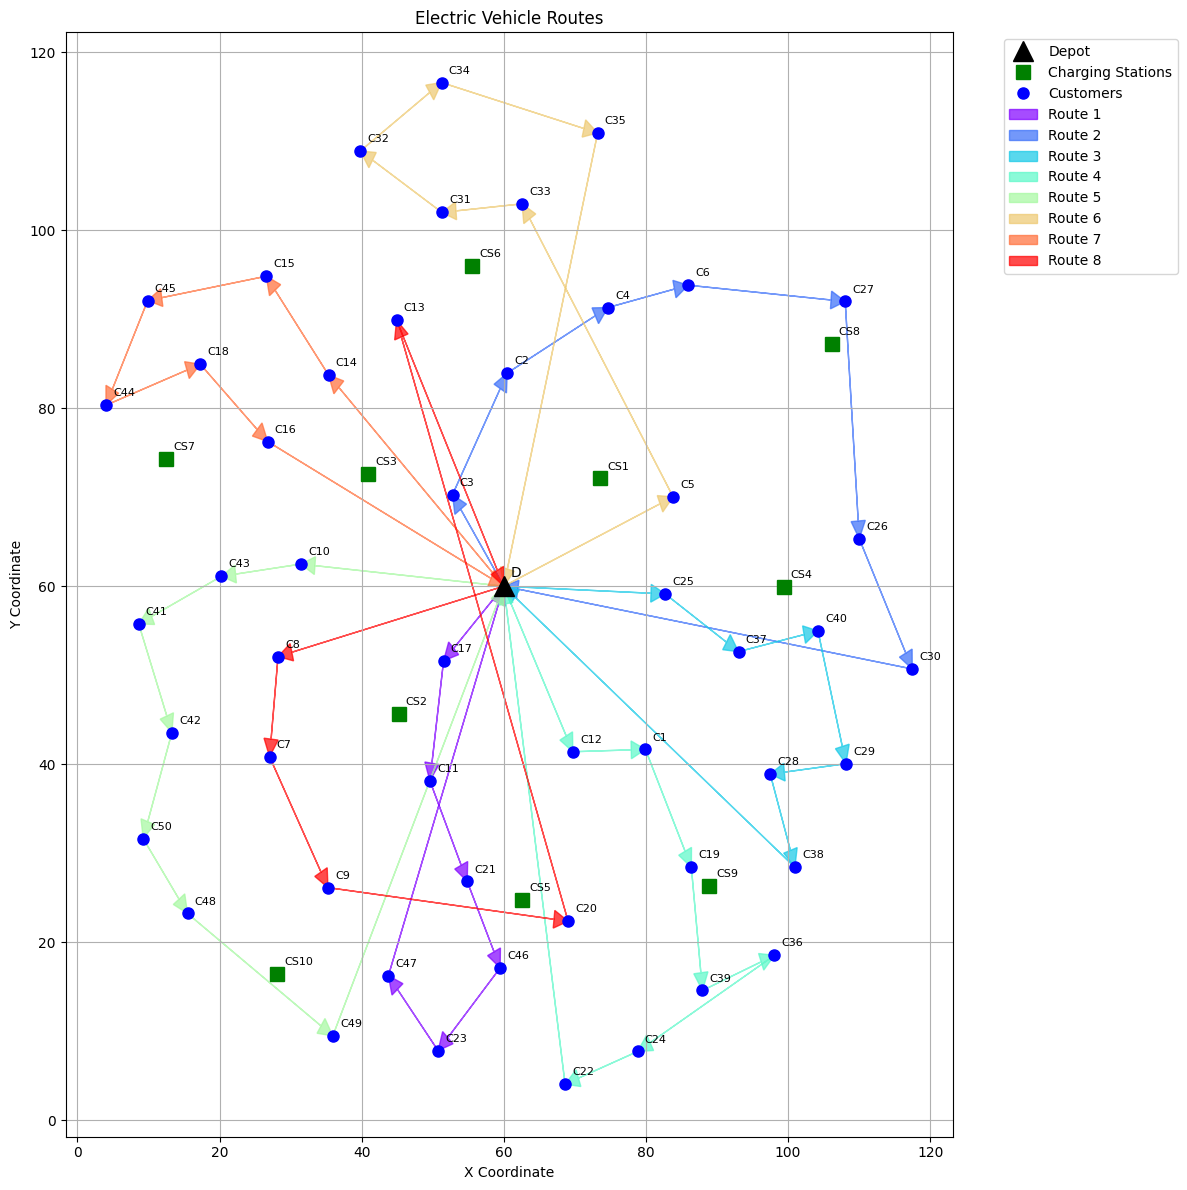

In [16]:

    
def run_ev_routing(toml_file_path):
    """Main function to run EV routing problem"""
    print(f"Loading data from {toml_file_path}...")
    
    # Read and validate input
    instance_data = read_toml_input(toml_file_path)
    
    # Create problem instance
    instance = EVRPInstance(
        instance_id=instance_data['instance_id'],
        depot_location=instance_data['depot_location'],
        customer_locations=instance_data['customer_locations'],
        charging_stations=instance_data['charging_stations'],
        customer_items_weights=instance_data['customer_items_weights'],
        charging_rate=instance_data['charging_rate']
    )
    
    # Print problem details
    print("\nProblem Instance Details:")
    print(f"Instance ID: {instance_data['instance_id']}")
    print(f"Number of Customers: {len(instance_data['customer_locations'])}")
    print(f"Number of Charging Stations: {len(instance_data['charging_stations'])}")
    print(f"Total Delivery Weight: {sum(instance_data['customer_items_weights'])} kg")
    print(f"Charging Rate: {instance_data['charging_rate']} kWh/h")
    
    # Create and run solver
    print("\nInitializing Greedy EVRP Solver...")
    solver = GreedyEVRPSolver(instance)
    
    print("Solving problem...")
    solution = solver.solve()
    
    # Print solution
    print("\n=== Solution Details ===")
    print(f"Total routes (vehicles used): {len(solution.routes)}")
    
    vehicle_counts = {}
    total_distance = 0
    total_energy = 0
    total_customers = 0
    
    for i, (route, v_type, load) in enumerate(zip(
            solution.routes, solution.vehicle_types, solution.route_loads)):
        
        # Calculate metrics including battery levels
        distance, energy, time, battery_levels = solver.calculate_route_metrics(route, load, v_type)
        
        # Update vehicle counts
        vehicle_counts[v_type] = vehicle_counts.get(v_type, 0) + 1
        
        print(f"\nRoute {i+1}:")
        print(f"Vehicle Type: {v_type.upper()}")
        print(f"Load: {load:.2f} kg")
        
        # Convert route to readable format with battery levels
        print("Sequence with battery levels:")
        for stop_idx, (loc, battery) in enumerate(battery_levels):
            if loc == 0:
                location_str = "D"  # Depot
            elif loc > 0:
                location_str = f"C{loc}"  # Customer
            else:
                location_str = f"CS{-loc}"  # Charging Station
            
            # Add arrow for all but last stop
            arrow = " → " if stop_idx < len(battery_levels) - 1 else ""
            print(f"{location_str} ({battery:.1f}%){arrow}", end="")
        print()  # New line after sequence
        
        print(f"Distance: {distance:.2f} km")
        print(f"Energy: {energy:.2f} kWh")
        print(f"Time: {time:.2f} hours")
        
        num_customers = sum(1 for loc in route if loc > 0)
        num_charges = sum(1 for loc in route if loc < 0)
        print(f"Customers served: {num_customers}")
        print(f"Charging stops: {num_charges}")
        
        total_distance += distance
        total_energy += energy
        total_customers += num_customers
    
    # Print summary statistics
    print("\n=== Overall Statistics ===")
    print("Vehicle Distribution:")
    for v_type, count in vehicle_counts.items():
        print(f"{v_type.upper()}: {count} vehicles")
    
    if total_distance > 0 and total_customers > 0:
        print(f"\nTotal distance: {total_distance:.2f} km")
        print(f"Total energy consumption: {total_energy:.2f} kWh")
        print(f"Average energy per km: {total_energy/total_distance:.3f} kWh/km")
        print(f"Total customers served: {total_customers}")
        print(f"Average distance per customer: {total_distance/total_customers:.2f} km")
    else:
        print("\nNo feasible routes were found!")
        print("Possible reasons:")
        print("- Vehicle capacity constraints")
        print("- Battery range limitations")
        print("- Distance/energy constraints")
        print("Consider adjusting vehicle parameters or problem constraints")
    
    print(f"Computation time: {solution.computation_time:.2f} seconds")

    
    # Plot solution
    print("\nGenerating visualization...")
    plt.figure(figsize=(12, 12))
    
    # Plot depot
    plt.plot(instance.depot_location[0], instance.depot_location[1], 
            'k^', markersize=15, label='Depot')
    plt.text(instance.depot_location[0] + 1, instance.depot_location[1] + 1, 
            'D', fontsize=10)
    
    # Plot charging stations
    charging_stations = np.array(instance.charging_stations)
    plt.plot(charging_stations[:, 0], charging_stations[:, 1], 
            'gs', markersize=10, label='Charging Stations')
    for i, (x, y) in enumerate(charging_stations):
        plt.text(x + 1, y + 1, f'CS{i+1}', fontsize=8)
    
    # Plot customers with numbers
    customers = np.array(instance.customer_locations)
    plt.plot(customers[:, 0], customers[:, 1], 
            'bo', markersize=8, label='Customers')
    for i, (x, y) in enumerate(customers):
        plt.text(x + 1, y + 1, f'C{i+1}', fontsize=8)
    
    # Plot routes with arrows to show direction
    colors = plt.cm.rainbow(np.linspace(0, 1, len(solution.routes)))
    all_locations = [instance.depot_location] + instance.customer_locations
    
    for route_idx, (route, color) in enumerate(zip(solution.routes, colors)):
        for i in range(len(route) - 1):
            # Get coordinates for current segment
            if route[i] >= 0:
                start = all_locations[route[i]]
            else:
                start = instance.charging_stations[-route[i]-1]
                
            if route[i+1] >= 0:
                end = all_locations[route[i+1]]
            else:
                end = instance.charging_stations[-route[i+1]-1]
            
            # Draw arrow
            plt.arrow(start[0], start[1], 
                     end[0] - start[0], end[1] - start[1],
                     head_width=2, head_length=2, fc=color, ec=color,
                     length_includes_head=True, alpha=0.7,
                     label=f'Route {route_idx+1}' if i == 0 else "")
    
    plt.title('Electric Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    
    # Move legend outside plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return solver, solution
        

if __name__ == "__main__":
    # Example usage
    toml_path = "/Users/chanakyavasantha/Comsets/test_cases/customers_50/c50_2.toml"
    solver, solution = run_ev_routing(toml_path)